In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from mpi4py import MPI
from lammps import lammps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
#me = MPI.COMM_WORLD.Get_rank()
#nprocs = MPI.COMM_WORLD.Get_size()

dI/dx=-aI-bI*I


I(x)=-a/b*exp(a/b*C)/(exp(a/b*C)-exp(ax))
a from here
https://www.pveducation.org/pvcdrom/materials/optical-properties-of-silicon

b is from here
https://aip.scitation.org/doi/full/10.1063/1.2737359
from border cond I(0)=I0:
C=b/a*ln(I0/(I0+a/b))
I(z)=I0a/((I0b+a)exp(ax)-I0b)
Fluence in J/cm2
wavelength in nm
pulselength in fs
porosity in %
zmax in nm
Iabsorbed=in J/cm3
to get 
Iabs per atom in ev
IabsEV=Iabs*M(g/mol)/(ro(g/cm3)*Na(mol-1))*6.24*10^18(ev/J) = Ia*28/(2.3*6.02*10^23)*6.24*10^18=12.61*10^-5Iabs
per fs in eV
IabsEV= 

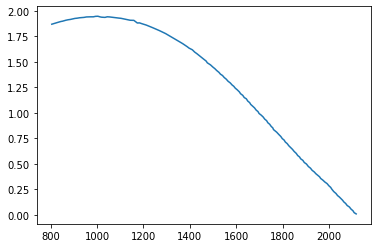

In [52]:
plt.plot(np.array(abs2)[:,0],np.array(abs2)[:,1])

In [32]:
abs1=pd.read_csv('silicon_1photon_extinction.txt', sep='\t') #cm-1
abs2=pd.read_csv('silicon_2photon_absorbance.txt', sep=' ') #cm/GW
heatcapacity=0.7 #(J/(g*K))
density=2.3 #(g/cm3)
def get1phabsorbance(wavelength, data):
    return np.interp(wavelength, data['wavelength(nm)'], data['a(/cm)'])
def get2phabsorbance(wavelength, data):
    # in cm/W
    return np.interp(wavelength, data['wavelength(nm)'], data['b(cm/GW)'])/1000000000
def calculate_tempdistr(wavelength, fluence, pulselength, porosity, zmax):
    T=[]
    I0=fluence/(pulselength/10**15)
    a=get1phabsorbance(wavelength, abs1)*(1-porosity)
    b=get2phabsorbance(wavelength, abs2)*(1-porosity)
    for i in range(zmax):
        H=I0*a/((I0*b+a)*np.exp(a*i*10**-7)-I0*b)
        Iabs=a*H+b*H*H
        T.append(Iabs*(pulselength/10**15)*density/heatcapacity)
        #T.append(Iabs*(pulselength/10**15))
        #T.append(H)
    return T
def calculate_tempdistrstring(wavelength, fluence, pulselength, porosity, zmax):
    I0=fluence/(pulselength/10**15)
    a=get1phabsorbance(wavelength, abs1)*(1-porosity)
    b=get2phabsorbance(wavelength, abs2)*(1-porosity)
    I=str(I0*a)+'/('+str(I0*b+a)+'*exp({})'.format(str(a*10**(-7))+'*(5.43*{Size}-z))').format(Size=zmax)+'-{})'.format(I0*b)
    #C=b/a*np.log(I0/(I0+a/b))
    #I='('+str(-a/b*np.exp(a/b*C))+'/'+'('+str(np.exp(a/b*C))+'-'+ 'exp({})'.format(str(a*10**(-7))+'*(5.43*{Size}-z)').format(Size=zmax)+')'+')'
    Iabs='('+str(a)+'*'+I+'+'+str(b)+'*'+I+'*'+I+')'+'*'+str(pulselength/10**15)
    return Iabs
def run(A):
    return 'run ' + str(A)

def createinputelectrontemp(filename ,nx,ny,nz,T0):
    x_ = np.linspace(0., nx-1., nx)
    y_ = np.linspace(0., ny-1., ny)
    z_ = np.linspace(0., nz-1., nz)
    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
    x=x.astype(int)
    y=y.astype(int)
    z=z.astype(int)
    hdl2=open('inputstemp/'+filename,'w+')
    for obj in zip(x.flatten(),y.flatten(),z.flatten()):
        T=float(T0*np.exp(-obj[2]))
        hdl2.write(str(obj[0])+' '+str(obj[1])+' '+str(obj[2])+' '+str(T)+'\n')
    hdl2.close()
    return 0
def calculate_heatstring(wavelength, fluence, pulselength, porosity, zmax):
    I0=fluence/(pulselength/10**15)
    a=get1phabsorbance(wavelength, abs1)*(1-porosity)
    b=get2phabsorbance(wavelength, abs2)*(1-porosity)
    C=b/a*np.log(I0/(I0+a/b))
    I=str(I0*a)+'/('+str(I0*b+a)+'*exp({})'.format(str(a*10**(-7))+'*(5.43*{Size}-z)').format(Size=zmax)+'-{})'.format(I0*b)
    #I='('+str(-a/b*np.exp(a/b*C))+'/'+'('+str(np.exp(a/b*C))+'-'+ 'exp({})'.format(str(a*10**(-7))+'*(5.43*{Size}-z)').format(Size=zmax)+')'+')'
    Heatsource='('+str(a)+'*'+I+'+'+str(b)+'*'+I+'*'+I+')'
    return Heatsource

In [3]:
C_e=0.00144
rho_e = 0.781
kappa_e = 0
gamma_p = 0.277 
gamma_s = 0.2191
v_0 = 0.0590
Nx = 10
Ny = 10
Nz = 10
N = 50

In [39]:
T= calculate_tempdistr(300, 1, 100000, 0.5, 50)


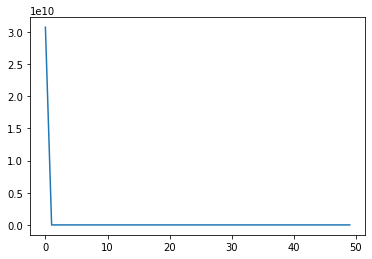

In [40]:
plt.plot(T)

In [21]:
def getscript( wavelength, fluence, pulselength,porosity,zmax, size, center, radius,inputfilename=''):
    Cylindertop = 50
    Cylinderbottom = 0
    filename= inputfilename
    fluxfilename='NPs_flux_output{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize'.format(wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    moviename ='3d{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    flatmoviename='flat{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    slicemoviename='slice{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    flatslicemoviename='flatslice{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    #INIT
    Initialize='''
    units metal
    atom_style atomic
    atom_modify map array
    dimension       3
    boundary        p p f
    '''
    #DEFINE REGIONS
    Regions=''' 
    lattice  diamond 5.43
    region 1 block 0 {Size} 0 {Size} 1 50 units lattice
    
    #region 3 cylinder z {Center} {Center} {Radius} {Cylinderbottom} {Cylindertop} units lattice 
    region 3 block 0 {Size} 0 {Size} 1 50 units lattice
    region centerslice block {slicex1} {slicex2} 0 {Size} 1 100 units lattice
    region todump block 0 {Size} 0 {Size} 52 100 units lattice
    '''.format(Size=size, Center=center, Radius=radius, 
               Cylinderbottom=Cylinderbottom, Cylindertop=Cylindertop,slicex1=size//2-2, slicex2=size//2)
    #CREATE ATOMS
    Atomcreation=''' 
        create_atoms 1 region 1
        '''
    #OR LOAD THEM FROM FILE
    Atomreading=''' 
        read_data {filename}
        '''.format(filename=filename)
    #ATOM GROUPS AND PARAMS
    Atomconfig=''' 
    group allatoms type 1
    group centeratoms1 region 3
    variable Nn equal count(all,todump)
    mass 1 28.0
    pair_style tersoff 
    pair_coeff * * Si.tersoff  Si
    neighbor 0.5 bin
    neigh_modify every 1 delay 1 check yes 
    '''
    #CALC CONFIG
    Calcconf=''' 
    thermo 10
    thermo_modify lost ignore flush yes
    velocity allatoms create 300 12345
    fix 2 all nve
    fix 3 all ave/time 1 1 1 v_Nn file {fluxfilename}
    compute coord all coord/atom cutoff 2.6
    '''.format(fluxfilename='outputs/'+fluxfilename)
    #DUMP CONFIG
    Dumpoptions=''' 
    dump  8  all  movie  2  {moviename}  c_coord  type  zoom  1.0  adiam  2.2  axes  yes  0.8  0.02  view  60  -30  size  2048  2048
    dump  9  all  movie  2  {flatmoviename}  c_coord  type  zoom  1.6  adiam  2.2  axes  yes  0.8  0.02  view  90  0  size  2048  2048
    dump  12  all  movie  2 {slicemoviename}  c_coord  type  zoom  1.0  adiam  2.2  axes  yes  0.8  0.02  view  60  -30  size  2048  2048
    dump  13  all  movie  2 {flatslicemoviename}  c_coord  type  zoom  1.6  adiam  2.2  axes  yes  0.8  0.02  view  90  0  size  2048  2048

    dump_modify 8 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green
    dump_modify 9 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green
    dump_modify 12 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green region centerslice
    dump_modify 13 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green region centerslice
    '''.format(moviename='outputs/'+moviename,flatmoviename='outputs/'+flatmoviename,
               slicemoviename='outputs/'+slicemoviename,flatslicemoviename='outputs/'+flatslicemoviename)
    #CREATE PULSEVELOCITYDIST
    #ev/ps
    createpulse=''' 
    variable heatsource atom ({heatsource})*1.1*10e-16
    fix 4 allatoms heat 1 v_heatsource region 3
    '''.format(heatsource=calculate_heatstring(wavelength, fluence, pulselength, porosity, zmax))
    #Removeheat
    Removeheat='''
    unfix 4
    '''
    #CREATE SCRIPT
    script=Initialize+Regions+Atomreading+ Atomconfig +Calcconf +Dumpoptions +run(100)+createpulse+run(pulselength)+Removeheat+run(1100-pulselength)
    return script

In [22]:
inputfilename='microporSi50percent_1010100.csv'
wavelength=300
fluence=1
pulselength=1000000 #fs
porosity=0.5
zmax=50
Size = 10
Center = 5.0
Radius = 2.0

In [17]:
#script=getscript(wavelength, fluence, 1000, porosity,zmax, Size, Center, Radius,inputfilename)
#for line in script.split('\n'):
#    print (line)

In [ ]:
for fluence in [1,2,5,10,20]:
    inputfilename='microporSi50percent_1010100.csv'
    porosity=0.5
    for wavelength in [300,400,500,600,700,800,900,1000]:
        for pulselength in [10,20,40,100,200,400,1000]:
            #hdl=open('torun/script_{}nm_{}Jcm2_{}fs_{}_por'.format(wavelength, fluence, pulselength, porosity),'w')
            lmp = lammps()
            print(wavelength,pulselength)
            script=getscript(wavelength, fluence, pulselength, porosity,zmax, Size, Center, Radius,inputfilename)
            for line in script.split('\n'):
            #hdl.write(script)
            #hdl.close()
                lmp.command(line)
    inputfilename='Si_1010100.csv'
    porosity=0
    for wavelength in [300,400,500,600,700,800,900,1000]:
        for pulselength in [10,20,40,100,200,400,1000]:
            #hdl=open('torun/script_{}nm_{}Jcm2_{}fs_{}_por'.format(wavelength, fluence, pulselength, porosity),'w')
            lmp = lammps()
            print(wavelength,pulselength)
            script=getscript(wavelength, fluence, pulselength, porosity,zmax, Size, Center, Radius,inputfilename)
            for line in script.split('\n'):
            #hdl.write(script)
            #hdl.close()
                lmp.command(line)
print("Proc %d out of %d procs has" % (me,nprocs), lmp)

300 10
300 20
300 40


In [ ]:
#from mpi4py import MPI
#comm = MPI.COMM_WORLD
#print ("Proc %d out of %d procs" % (comm.Get_rank(),comm.Get_size()))

In [ ]:
x1=[]
y1=[]
y2=[]
for k in range(300,1100, 10):
    x1.append(k)
    y1.append(get1phabsorbance(k,abs1))
    y2.append(get2phabsorbance(k,abs2))
#plt.plot(x1,y1)
#plt.plot(x1,y2)

In [23]:
%matplotlib auto
Xsez=[]
Ysez=[]
Zsez=[]
c=[]
Fl=[]
for filename in ['outputs/'+file for file in os.listdir('outputs') if file.startswith('NPs_')]:
    print (filename)
    #try:
    flux=pd.read_csv(filename,sep=' ', header=2).iloc[-1]['0.1']
    wavelength=float(filename.split('output')[-1].split('nm')[-3])
    fluence=float(filename.split('J')[-2].split('nm')[-1])
    pulselength=float(filename.split('fs')[-2].split('cm2')[-1])
    porous=float(filename.split('por')[-2].split('fs')[-1])
    #print(np.log(pulselength))
    #if pulselength>0:
    #    if wavelength>0 and porous>0.1:
    Xsez.append(np.log10(pulselength))#np.log(pulselength))
    Ysez.append(wavelength)
    Zsez.append(flux)
    c.append(porous)
    Fl.append(fluence)
    #except:
    #    None
    #print(flux,wavelength,pulselength)

#fig = plt.figure()
#ax = Axes3D(fig) 
#ax.scatter(np.log(Xsez),Ysez,Zsez, c=c)
#ax.plot_trisurf(Xsez,Ysez,Zsez)
#ax = Axes3D(fig) 
#ax.scatter(np.array(Xsez), np.array(Ysez), np.array(Zsez), 1, cmap='viridis', edgecolor='none')
#ax.set_title('surface');

Using matplotlib backend: Qt5Agg
outputs/NPs_flux_output500nm2Jcm240fs0.5por10nmsize
outputs/NPs_flux_output1000nm20Jcm2200fs0por10nmsize
outputs/NPs_flux_output500nm2Jcm2200fs0.5por10nmsize
outputs/NPs_flux_output400nm20Jcm220fs0por10nmsize
outputs/NPs_flux_output900nm10Jcm2200fs0.5por10nmsize
outputs/NPs_flux_output500nm1Jcm2200fs0.5por10nmsize
outputs/NPs_flux_output800nm2Jcm210fs0.5por10nmsize
outputs/NPs_flux_output500nm20Jcm2200fs0por10nmsize
outputs/NPs_flux_output500nm2Jcm210fs0por10nmsize
outputs/NPs_flux_output800nm1Jcm220fs0.5por10nmsize
outputs/NPs_flux_output400nm1Jcm2400fs0por10nmsize
outputs/NPs_flux_output1000nm5Jcm2200fs0por10nmsize
outputs/NPs_flux_output300nm2Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output900nm2Jcm2200fs0por10nmsize
outputs/NPs_flux_output700nm5Jcm210fs0.5por10nmsize
outputs/NPs_flux_output1000nm5Jcm21000fs0por10nmsize
outputs/NPs_flux_output1000nm5Jcm210fs0por10nmsize
outputs/NPs_flux_output500nm10Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output300nm

outputs/NPs_flux_output300nm5Jcm240fs0.5por10nmsize
outputs/NPs_flux_output1000nm1Jcm2100fs0por10nmsize
outputs/NPs_flux_output600nm5Jcm220fs0.5por10nmsize
outputs/NPs_flux_output400nm20Jcm240fs0por10nmsize
outputs/NPs_flux_output600nm5Jcm2400fs0por10nmsize
outputs/NPs_flux_output600nm10Jcm220fs0.5por10nmsize
outputs/NPs_flux_output800nm20Jcm220fs0.5por10nmsize
outputs/NPs_flux_output400nm5Jcm240fs0.5por10nmsize
outputs/NPs_flux_output500nm5Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output900nm2Jcm21000fs0por10nmsize
outputs/NPs_flux_output400nm5Jcm210fs0por10nmsize
outputs/NPs_flux_output400nm20Jcm2200fs0por10nmsize
outputs/NPs_flux_output600nm5Jcm21000fs0.5por10nmsize
outputs/NPs_flux_output800nm5Jcm2100fs0por10nmsize
outputs/NPs_flux_output900nm20Jcm220fs0por10nmsize
outputs/NPs_flux_output300nm10Jcm2400fs0.5por10nmsize
outputs/NPs_flux_output800nm20Jcm210fs0.5por10nmsize
outputs/NPs_flux_output300nm10Jcm2200fs0por10nmsize
outputs/NPs_flux_output900nm5Jcm2400fs0.5por10nmsize
outputs/N

outputs/NPs_flux_output900nm10Jcm240fs0por10nmsize
outputs/NPs_flux_output500nm5Jcm240fs0por10nmsize
outputs/NPs_flux_output600nm1Jcm240fs0por10nmsize
outputs/NPs_flux_output900nm2Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output800nm2Jcm220fs0.5por10nmsize
outputs/NPs_flux_output700nm1Jcm240fs0.5por10nmsize
outputs/NPs_flux_output400nm2Jcm240fs0por10nmsize
outputs/NPs_flux_output500nm20Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output600nm2Jcm2400fs0por10nmsize
outputs/NPs_flux_output900nm5Jcm240fs0.5por10nmsize
outputs/NPs_flux_output800nm5Jcm240fs0por10nmsize
outputs/NPs_flux_output700nm10Jcm2400fs0.5por10nmsize
outputs/NPs_flux_output1000nm20Jcm2100fs0por10nmsize
outputs/NPs_flux_output600nm1Jcm2200fs0por10nmsize
outputs/NPs_flux_output300nm5Jcm21000fs0.5por10nmsize
outputs/NPs_flux_output1000nm2Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output300nm1Jcm2400fs0por10nmsize
outputs/NPs_flux_output800nm5Jcm2100fs0.5por10nmsize
outputs/NPs_flux_output600nm1Jcm21000fs0por10nmsize
outputs/NPs_f

In [24]:
Alldata=pd.DataFrame(columns=['pulselegth', 'wavelength', 'flux', 'porosity', 'fluence'])
for pulselength, wavelength, flux, porosity, fluence in zip(Xsez,Ysez, Zsez, c,Fl):
    Alldata.loc[len(Alldata)]=(pulselength, wavelength, flux, porosity, fluence)
    #print (pulselength, wavelength, flux, porosity, fluence)

In [25]:
Alldata.to_pickle('alldata_allsurface.pkl')

In [26]:
#selected=Alldata[Alldata['porosity']==0][Alldata['fluence']==0.1]
fig = plt.figure()
ax = Axes3D(fig) 
selected=Alldata[Alldata['porosity']==0][Alldata['fluence']==1]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0][Alldata['fluence']==2]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0][Alldata['fluence']==5]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0][Alldata['fluence']==10]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0][Alldata['fluence']==20]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [ ]:
selected=Alldata[Alldata['porosity']==0.5]#[Alldata['fluence']==20]

In [ ]:
selected

In [13]:
fig = plt.figure()
ax = Axes3D(fig) 
selected=Alldata[Alldata['porosity']==0.5][Alldata['fluence']==1]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0.5][Alldata['fluence']==2]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0.5][Alldata['fluence']==5]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0.5][Alldata['fluence']==10]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])
selected=Alldata[Alldata['porosity']==0.5][Alldata['fluence']==20]
ax.plot_trisurf(selected['pulselegth'],selected['wavelength'],selected['flux'])

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
A=list(set(np.log(Xsez)))
A.sort()
A=np.array(A)
B=list(set(Ysez))
B.sort()
B=np.array(B)

In [ ]:
x_ = np.linspace(0., nx-1., nx)
y_ = np.linspace(0., ny-1., ny)
z_ = np.linspace(0., nz-1., nz)
x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
x=x.astype(int)
y=y.astype(int)
z=z.astype(int)
    #hdl2=open('inputstemp/'+filename,'w+')
for obj in zip(x.flatten(),y.flatten(),z.flatten()):
    #T=T0*np.exp(-z)
    #hdl2.write(str(obj[0])+str(obj[1])+str(obj[2])+str(T)+'\n')
    A=0

In [ ]:
wavelength=300
fluence=0.1
createscript('in.porousfalse_{}nm{}Jcm2'.format(wavelength,fluence), size=100, porous=True, fluence=fluence, alpha=get1phabsorbance(wavelength, abs1), beta=get2phabsorbance(wavelength, abs2))

In [ ]:
get1phabsorbance(400, abs1)

In [ ]:
for scriptname in os.listdir('scripts'):
    print ('CALL lmp_serial -in {} -pk omp 4 -sf omp'.format(scriptname))

In [ ]:
plt.plot(calculate_tempdistr(300, 0.1, 1000000, 0.1, 100))